In [1]:
# os: use operating system dependent functions
import os

# pandas: handle the datasets in the pandas dataframe for data processing and analysis
import pandas as pd
print("pandas version: {}". format(pd.__version__))

# numpy: support for large, multi-dimensional arrays and matrices and high-level mathematical functions
import numpy as np
print("numpy version: {}". format(np.__version__))

# sklearn: machine learning and data preperation
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
print("sklearn version: {}". format(sklearn.__version__))

# matplotlib: standard library to create visualizations
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

# seaborn: advanced visualization library to create more advanced charts
import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

# turn out warnings for better reading in the Jupyter notebbok
pd.options.mode.chained_assignment = None  # default='warn'

pandas version: 1.3.4
numpy version: 1.20.3
sklearn version: 0.24.2
matplotlib version: 3.4.3
seaborn version: 0.11.2


In [2]:
# load prepared training and test dataset
df_train = pd.read_pickle('../03_dataPreprocessing/df_train_prepared.pkl')
df_test = pd.read_pickle('../03_dataPreprocessing/df_test_prepared.pkl')

In [3]:
# split the training and test dataset to the input features (x_train, x_test) and the survival class (y_train)
y_train = df_train['SalePrice']
x_train = df_train.drop(['SalePrice'], axis=1)
x_test = df_test

In [4]:
def train_model(ml_algo, param_grid, x_train=x_train, y_train=y_train):
    
    # numeric features that are Standard Scaled
    transformer_num = x_train.columns

    # creation of column transformer
    # features that are not in the transformer_cat or transformer_num array are passed through this pipeline step and not deleted
    col_transform = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), transformer_num)
        ], remainder='passthrough'
    )
    
    
    # define pipeline
    pipeline = Pipeline(steps=[
        ('columnprep', col_transform),
        ('reducedim', PCA()),
        ('regression', ml_algo)
    ])
    
    
    # create grid seach object for the whole pipeline
    grid_search = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grid,
        n_jobs = -1,
        refit = True,
        verbose = 1,
        cv=5)
    
    
    grid_search.fit(x_train, y_train)
    
    print(grid_search.best_params_)
    
    return grid_search

In [5]:
def evaluate_model(grid_search, x_train=x_train, y_train=y_train):
    
    # predict the training outcome
    y_training_pred = grid_search.best_estimator_.predict(x_train)

    print("RMSE: {:.0f}".format(mean_squared_error(y_train, y_training_pred, squared=True)))
    print("R2: {:.2f}".format(r2_score(y_train, y_training_pred)))
    
    # plot the actual and predicted values of the training set
    plt.scatter(y_train, y_training_pred)
    plt.plot([min(y_training_pred),max(y_training_pred)], [min(y_training_pred),max(y_training_pred)], c="red")
    plt.xlabel('True Sales Price')
    plt.ylabel('Predicted Sales Price')
    plt.show()

In [6]:
def create_submission(grid_search, name, x_test=x_test):
    pred_test = grid_search.predict(x_test)
    submission_test = pd.read_csv("E:/Data Science Projects/90_Kaggle/kaggle_house_prices/01_rawdata/sample_submission.csv")
    submission_test.iloc[:, 1] = pred_test
    submission_test.to_csv("{}_submission_test.csv".format(name), index=False)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'reducedim__n_components': 112, 'regression__alpha': 2, 'regression__l1_ratio': 1}
RMSE: 374582893
R2: 0.92


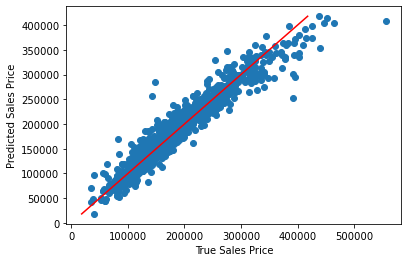

In [7]:
# define the regression algorithm
ml_algo = ElasticNet(warm_start=True)

# define the parameters for grid search
param_grid = [{
    'reducedim__n_components': [70, 80, 100, 112],
    'regression__alpha': [0.5, 1, 1.5, 2],
    'regression__l1_ratio': [0, 0.5, 1]
}]

grid_search = train_model(ml_algo, param_grid)
evaluate_model(grid_search)
create_submission(grid_search, "ElasticNet")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'reducedim__n_components': 112, 'regression__C': 250, 'regression__epsilon': 1}
RMSE: 416922543
R2: 0.91


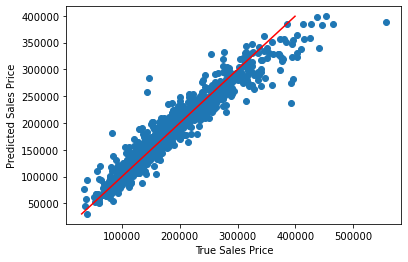

In [8]:
# define the regression algorithm
ml_algo = SVR(kernel="linear")

# define the parameters for grid search
param_grid = [{
    'reducedim__n_components': [90, 100, 112],
    'regression__C': [150, 200, 250],
    'regression__epsilon': [0.005, 0.01, 0.1, 0.2, 0.5, 1]
}]

grid_search = train_model(ml_algo, param_grid)
evaluate_model(grid_search)
create_submission(grid_search, "SVR")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'reducedim__n_components': 10, 'regression__max_depth': 8, 'regression__min_samples_leaf': 4, 'regression__min_samples_split': 3, 'regression__n_estimators': 100}
RMSE: 257824881
R2: 0.95


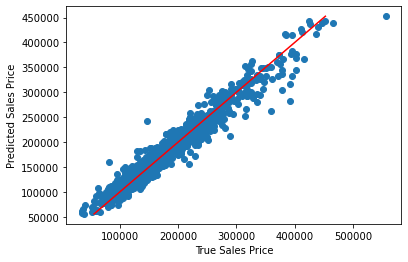

In [9]:
# define the regression algorithm
ml_algo = RandomForestRegressor(warm_start=True, n_jobs=-1)

# define the parameters for grid search
param_grid = [{
    'reducedim__n_components': [10, 20, 30, 50],
    'regression__max_depth': [4, 6, 8],
    'regression__n_estimators': [100, 150, 200],
    'regression__min_samples_split': [2, 3],
    'regression__min_samples_leaf': [4, 6]
}]

grid_search = train_model(ml_algo, param_grid)
evaluate_model(grid_search)
create_submission(grid_search, "RandomForestRegressor")